In [4]:
%matplotlib inline
import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [2]:
from quat_math import quat2AxisAngle

def quats2Point(quats):
    pts = []
    for q in quats:
        xi, theta = quat2AxisAngle(q)
        pts.append(xi*theta)
    return np.array(pts)

def scatterSO3(vertices, vals, q_gt = None, alpha_max = 1.0):
    #c = cmap(vals)
    a = np.maximum(0,np.minimum(1, (vals - min(vals))/(max(vals) - min(vals))))
    c = cmap(a)
    
    c[:,3] = alpha_max*a

    pts = quats2Point(vertices)
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=a*10, c=c)

    if(q_gt is not None):
        pt_gt = quats2Point(q_gt)
        ax.scatter(pt_gt[:,0], pt_gt[:,1], pt_gt[:,2], c='r', marker='x')

In [3]:
from transforms3d.quaternions import quat2mat, mat2quat

def getPoseCNNQuat(data, obj):
    pose_idx = np.where(data['rois'][:,1].flatten()==obj)[0]
    if(len(pose_idx) == 0):
        return None
    else:
        pose_idx = pose_idx[0]
    pose = data['poses'][pose_idx]
    q = pose[:4][[1,2,3,0]]
    q /= np.linalg.norm(q)
    t = pose[4:7]
    return q


In [4]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.feature_dataset import FeatureDataset

from object_pose_utils.datasets.image_processing import ImageNormalizer
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
object_list = list(range(1,22))
mode = "test"

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.IMAGE_CROPPED, 
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES]



In [5]:
feature_root = '/scratch/bokorn/results/posecnn_feat_all/'
test_feature_root = feature_root
feature_key = 'fc6'

comp_model_checkpoint = '/scratch/bokorn/results/multi_object/pcnn_fc6/trainval_lr_1e-6_top_x2000/2019-07-04_01-06-36/all/weights/checkpoint_44000.pth'
feature_size = 4096

sigmas = np.load('../notebooks/fc6_sigma.npz', allow_pickle=True)['sigmas'].item()

In [6]:
sigmas

{1: 0.0027629295374846374,
 2: 0.0027629295374846374,
 3: 0.004795584226429728,
 4: 0.0027629295374846374,
 5: 0.0027629295374846374,
 6: 0.0027629295374846374,
 7: 0.0027629295374846374,
 8: 0.01011714328948149,
 9: 0.0027629295374846374,
 10: 0.004795584226429728,
 11: 0.0027629295374846374,
 12: 0.0080844886005364,
 13: 0.0027629295374846374,
 14: 0.004795584226429728,
 15: 0.0027629295374846374,
 16: 0.0080844886005364,
 17: 0.0027629295374846374,
 18: 0.0027629295374846374,
 19: 0.0080844886005364,
 20: 0.0027629295374846374,
 21: 0.01011714328948149}

In [2]:
ls ../notebooks/fc6_sigma.npz

../notebooks/fc6_sigma.npz


In [7]:
from se3_distributions.models.compare_networks import SigmoidCompareNet

estimator_comp = SigmoidCompareNet(feature_size, 21)
estimator_comp.load_state_dict(torch.load(comp_model_checkpoint))
estimator_comp.cuda();

from object_pose_utils.utils.interpolation import BinghamInterpolation, TetraInterpolation
from object_pose_utils.utils.bingham import isobingham_likelihood
tetra_interp = TetraInterpolation(2)


In [20]:
from se3_distributions.datasets.ycb_dataset import getYCBSymmeties
from object_pose_utils.utils.pose_processing import symmetricAngularDistance, meanShift
import pathlib


import scipy.io as scio
from tqdm import tqdm_notebook as tqdm

grid_size = 3885
rep_indices = np.repeat(np.arange(1), grid_size)

err_compare = {}
err_bing = {}

lik_compare = {}
lik_bing = {}

interp_sigma = 60.0

with torch.no_grad():
    for object_id in tqdm(object_list):
        sym_axis, sym_ang = getYCBSymmeties(object_id)
        ycb_dataset = FeatureDataset(dataset_root = dataset_root,
                                     feature_root = test_feature_root,
                                     feature_key = feature_key,
                                     resample_on_error = False,
                                     mode=mode, object_list = [object_id])
        grid_vertices = torch.load(os.path.join(feature_root, 'grid',
            '{}_vertices.pt'.format(ycb_dataset.classes[object_id])))
        grid_features = torch.load(os.path.join(feature_root, 'grid',
            '{}_{}_features.pt'.format(feature_key,ycb_dataset.classes[object_id])))

        grid_size = grid_vertices.shape[0]
        grid_features = to_var(grid_features)
        rep_indices = np.repeat(np.arange(1), grid_size)

        bing_interp = BinghamInterpolation(torch.tensor(grid_vertices).cuda(),
                                           sigma=torch.tensor([interp_sigma]).cuda())

        
        lik_compare[object_id] = []
        err_compare[object_id] = []
        lik_bing[object_id] = []
        err_bing[object_id] = []
        
        pathlib.Path('results/data'.format(ycb_dataset.classes[object_id])).mkdir(parents=True, exist_ok=True)
        
        for j, data in tqdm(enumerate(ycb_dataset), total=len(ycb_dataset)):
            obj, feat, quat = data
            if(len(obj) == 0):
                lik_compare[object_id].append(np.nan)
                err_compare[object_id].append(np.nan)
                lik_bing[object_id].append(np.nan)
                err_bing[object_id].append(np.nan)
                continue
            feature_data = np.load('{}/data/{}_{}_feat.npz'.format(ycb_dataset.feature_root, 
                ycb_dataset.getPath(j), ycb_dataset.classes[obj]))

            pcnn_mat = scio.loadmat('{}/data/{}-posecnn.mat'.format(ycb_dataset.dataset_root, ycb_dataset.getPath(j)))
            est_quat = torch.tensor(getPoseCNNQuat(pcnn_mat, obj.item())).float()
            
            idx = torch.autograd.Variable(obj - 1).unsqueeze(0).cuda()
            feat = to_var(feat).unsqueeze(0)

            dist_est = estimator_comp(grid_features, feat[rep_indices])
            dist_est = torch.gather(dist_est, 1, idx[rep_indices])
            dist_est = torch.exp(dist_est)
            bing_interp.setValues(dist_est.flatten().cuda())
            v_interp = bing_interp(quat.unsqueeze(0).cuda())
            lik_compare[object_id].append(v_interp.item())
            
#            tetra_interp.setValues(to_np(dist_est.flatten()))
#            lik_compare[object_id].append(tetra_interp.smooth(to_np(quat)).item())
            
#            lik_bing[object_id].append(isobingham_likelihood(est_quat.cuda(), 
#                                torch.tensor(sigmas[obj.item()]).unsqueeze(0).float().cuda(),
#                                quat.unsqueeze(0).cuda()).item()*2)
            
            mode_quat = grid_vertices[torch.argmax(dist_est)].unsqueeze(0)
            
            v_shift = meanShift(mode_quat.cuda(), grid_vertices.cuda(), dist_est.cuda(),
                                sigma=np.pi/9, max_iter = 100)
            
            err_compare[object_id].append(symmetricAngularDistance(mode_quat, quat.unsqueeze(0),
                                             sym_axis, sym_ang).item()*180/np.pi)
            
#            err_bing[object_id].append(symmetricAngularDistance(est_quat.unsqueeze(0), quat.unsqueeze(0),
#                                           sym_axis, sym_ang).item()*180/np.pi)
            
            savepath = 'results/{}'.format(ycb_dataset.getPath(j))
            pathlib.Path(savepath).mkdir(parents=True, exist_ok=True)
            
            scio.savemat('{}/{}_{}_results_b_interp.mat'.format(savepath, 
                                                    ycb_dataset.classes[object_id], 
                                                    ycb_dataset.feature_key),
                        {'index':j,
                         'quat':to_np(quat),
                         'mode_quat':to_np(mode_quat),
                         'dist_est':to_np(dist_est),
                         'comp_err':err_compare[object_id][-1],
                         'comp_lik':lik_compare[object_id][-1],
                         'interp_sigma':interp_sigma,
#                         'pcnn_quat':to_np(est_quat),
#                         'pcnn_err':err_bing[object_id][-1],
#                         'pcnn_lik':lik_bing[object_id][-1],
#                         'sigma':sigmas[obj.item()],
                         })
np.savez('results/posecnn_bing_comp_b_interp.npz', 
         err_compare=err_compare,
         lik_compare=lik_compare,
         err_bing=err_bing,
         lik_bing=lik_bing)

/home/bokorn/src/se3_distributions/bpy/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Exception on index 40: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000505_005_tomato_soup_can_feat.npz'
Exception on index 41: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000509_005_tomato_soup_can_feat.npz'
Exception on index 42: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000558_005_tomato_soup_can_feat.npz'
Exception on index 43: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000588_005_tomato_soup_can_feat.npz'
Exception on index 44: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000605_005_tomato_soup_can_feat.npz'
Exception on index 45: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000610_005_tomato_soup_can_feat.npz'
Exception on index 46: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data

Exception on index 408: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000037_010_potted_meat_can_feat.npz'
Exception on index 413: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000088_010_potted_meat_can_feat.npz'
Exception on index 426: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000153_010_potted_meat_can_feat.npz'
Exception on index 427: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000154_010_potted_meat_can_feat.npz'
Exception on index 429: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000158_010_potted_meat_can_feat.npz'
Exception on index 432: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000162_010_potted_meat_can_feat.npz'
Exception on index 433: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_a

Exception on index 57: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000653_051_large_clamp_feat.npz'
Exception on index 58: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000656_051_large_clamp_feat.npz'
Exception on index 61: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000685_051_large_clamp_feat.npz'
Exception on index 62: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000694_051_large_clamp_feat.npz'
Exception on index 63: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000733_051_large_clamp_feat.npz'
Exception on index 69: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000806_051_large_clamp_feat.npz'
Exception on index 73: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000834_051_large_c

Exception on index 503: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000830_052_extra_large_clamp_feat.npz'
Exception on index 505: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000836_052_extra_large_clamp_feat.npz'
Exception on index 507: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000839_052_extra_large_clamp_feat.npz'
Exception on index 515: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000851_052_extra_large_clamp_feat.npz'
Exception on index 518: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000890_052_extra_large_clamp_feat.npz'
Exception on index 519: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000897_052_extra_large_clamp_feat.npz'
Exception on index 521: [Errno 2] No such file or directory: '/scratch/bokorn/results/po

Exception on index 583: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001181_052_extra_large_clamp_feat.npz'
Exception on index 584: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001185_052_extra_large_clamp_feat.npz'
Exception on index 585: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001190_052_extra_large_clamp_feat.npz'
Exception on index 586: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001215_052_extra_large_clamp_feat.npz'
Exception on index 587: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001245_052_extra_large_clamp_feat.npz'
Exception on index 588: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001250_052_extra_large_clamp_feat.npz'
Exception on index 589: [Errno 2] No such file or directory: '/scratch/bokorn/results/po

In [17]:

bing_interp.setValues(dist_est.flatten().cuda())
v_interp = bing_interp(quat.unsqueeze(0).cuda())
v_interp

tensor([0.7964], device='cuda:0')

In [15]:
for obj in range(1,22):
    print(obj, np.mean(np.log(lik_compare[obj])))


1 -0.40790476151382826
2 -0.7305662173709558
3 0.20249328938311445
4 nan
5 0.5712280902598553
6 -0.6430081862748637
7 -0.12432309807009279
8 0.2666642819335662
9 nan
10 -0.5302715713830018
11 0.12597488542521892
12 -0.08206429349150424
13 -1.5151178315905067
14 -0.1313318350979402
15 -0.14961209895416755
16 -1.2024978843256964
17 -0.6238489380862798
18 -0.8301426705513344
19 nan
20 nan
21 -1.4880463923440006


In [184]:
from se3_distributions.datasets.ycb_dataset import getYCBSymmeties
from object_pose_utils.utils.pose_processing import symmetricAngularDistance, meanShift, unique_tol
import pathlib


import scipy.io as scio
from tqdm import tqdm_notebook as tqdm

grid_size = 3885
rep_indices = np.repeat(np.arange(1), grid_size)

err_bing = {}
err_compare = {}
err_compare_max_shift = {}
err_compare_all_shift = {}


with torch.no_grad():
    for object_id in tqdm(object_list):
        sym_axis, sym_ang = getYCBSymmeties(object_id)
        ycb_dataset = FeatureDataset(dataset_root = dataset_root,
                                     feature_root = test_feature_root,
                                     feature_key = feature_key,
                                     resample_on_error = False,
                                     mode=mode, object_list = [object_id])
        grid_vertices = torch.load(os.path.join(feature_root, 'grid',
            '{}_vertices.pt'.format(ycb_dataset.classes[object_id])))
        grid_features = torch.load(os.path.join(feature_root, 'grid',
            '{}_{}_features.pt'.format(feature_key,ycb_dataset.classes[object_id])))

        grid_size = grid_vertices.shape[0]
        grid_features = to_var(grid_features)
        rep_indices = np.repeat(np.arange(1), grid_size)
        
        
        err_compare[object_id] = []
        err_compare_max_shift[object_id] = []
        err_compare_all_shift[object_id] = []
        err_bing[object_id] = []
        
        pathlib.Path('results/data'.format(ycb_dataset.classes[object_id])).mkdir(parents=True, exist_ok=True)
        
        for j, data in tqdm(enumerate(ycb_dataset), total=len(ycb_dataset)):
            obj, feat, quat = data
            if(len(obj) == 0):
                continue
            
            feature_data = np.load('{}/data/{}_{}_feat.npz'.format(ycb_dataset.feature_root, 
                ycb_dataset.getPath(j), ycb_dataset.classes[obj]))

            pcnn_mat = scio.loadmat('{}/data/{}-posecnn.mat'.format(ycb_dataset.dataset_root, ycb_dataset.getPath(j)))
            est_quat = torch.tensor(getPoseCNNQuat(pcnn_mat, obj.item())).float()
            
            idx = torch.autograd.Variable(obj - 1).unsqueeze(0).cuda()
            feat = to_var(feat).unsqueeze(0)

            dist_est = estimator_comp(grid_features, feat[rep_indices])
            dist_est = torch.gather(dist_est, 1, idx[rep_indices])
            
            mode_quat = grid_vertices[torch.argmax(dist_est)].unsqueeze(0)
            
            v_shift = meanShift(mode_quat.cuda(), grid_vertices.cuda(), dist_est.cuda(),
                                sigma=np.pi/9, max_iter = 100)
            
            err_compare[object_id].append(symmetricAngularDistance(mode_quat, quat.unsqueeze(0),
                                             sym_axis, sym_ang).item()*180/np.pi)
            
            err_compare_max_shift[object_id].append(symmetricAngularDistance(v_shift.cpu(), quat.unsqueeze(0),
                                                 sym_axis, sym_ang).item()*180/np.pi)
            
            #v_shift_all = meanShift(grid_vertices.cuda(), grid_vertices.cuda(), dist_est.cuda(),
            #                    sigma=np.pi/9, max_iter = 100)            
            #v_shift_all = unique_tol(v_shift_all)
            #tetra_interp.setValues(to_np(dist_est.flatten()))            
            #err_compare_all_shift[object_id].append(symmetricAngularDistance(
            #    v_shift_all[np.argmax(tetra_interp.smooth(to_np(v_shift_all)))].cpu(),
            #    quat.unsqueeze(0),sym_axis, sym_ang).item()*180/np.pi)
            
            err_bing[object_id].append(symmetricAngularDistance(est_quat.unsqueeze(0), quat.unsqueeze(0),
                                           sym_axis, sym_ang).item()*180/np.pi)

np.savez('results/posecnn_bing_comp_mean_shift.npz', 
         err_compare=err_compare,
         err_compare_max_shift=err_compare_max_shift)

Exception on index 40: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000505_005_tomato_soup_can_feat.npz'
Exception on index 41: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000509_005_tomato_soup_can_feat.npz'
Exception on index 42: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000558_005_tomato_soup_can_feat.npz'
Exception on index 43: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000588_005_tomato_soup_can_feat.npz'
Exception on index 44: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000605_005_tomato_soup_can_feat.npz'
Exception on index 45: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0050/000610_005_tomato_soup_can_feat.npz'
Exception on index 46: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data

Exception on index 408: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000037_010_potted_meat_can_feat.npz'
Exception on index 413: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000088_010_potted_meat_can_feat.npz'
Exception on index 426: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000153_010_potted_meat_can_feat.npz'
Exception on index 427: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000154_010_potted_meat_can_feat.npz'
Exception on index 429: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000158_010_potted_meat_can_feat.npz'
Exception on index 432: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0059/000162_010_potted_meat_can_feat.npz'
Exception on index 433: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_a

Exception on index 57: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000653_051_large_clamp_feat.npz'
Exception on index 58: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000656_051_large_clamp_feat.npz'
Exception on index 61: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000685_051_large_clamp_feat.npz'
Exception on index 62: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000694_051_large_clamp_feat.npz'
Exception on index 63: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000733_051_large_clamp_feat.npz'
Exception on index 69: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000806_051_large_clamp_feat.npz'
Exception on index 73: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0048/000834_051_large_c

Exception on index 503: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000830_052_extra_large_clamp_feat.npz'
Exception on index 505: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000836_052_extra_large_clamp_feat.npz'
Exception on index 507: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000839_052_extra_large_clamp_feat.npz'
Exception on index 515: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000851_052_extra_large_clamp_feat.npz'
Exception on index 518: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000890_052_extra_large_clamp_feat.npz'
Exception on index 519: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/000897_052_extra_large_clamp_feat.npz'
Exception on index 521: [Errno 2] No such file or directory: '/scratch/bokorn/results/po

Exception on index 583: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001181_052_extra_large_clamp_feat.npz'
Exception on index 584: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001185_052_extra_large_clamp_feat.npz'
Exception on index 585: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001190_052_extra_large_clamp_feat.npz'
Exception on index 586: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001215_052_extra_large_clamp_feat.npz'
Exception on index 587: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001245_052_extra_large_clamp_feat.npz'
Exception on index 588: [Errno 2] No such file or directory: '/scratch/bokorn/results/posecnn_feat_all/data/0057/001250_052_extra_large_clamp_feat.npz'
Exception on index 589: [Errno 2] No such file or directory: '/scratch/bokorn/results/po

In [190]:
np.mean(np.array(err_compare[object_id]) - np.array(err_compare_max_shift[object_id]))

12.449210373784434

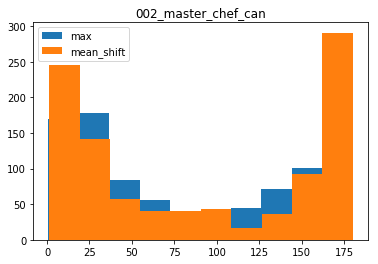

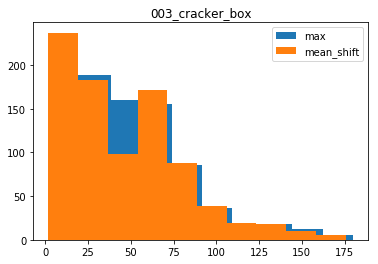

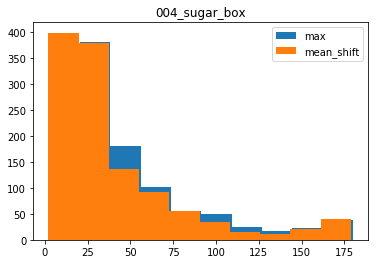

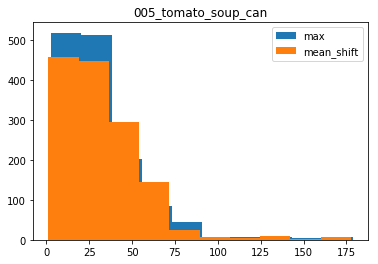

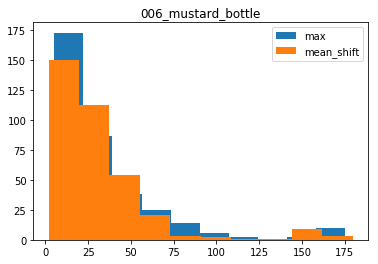

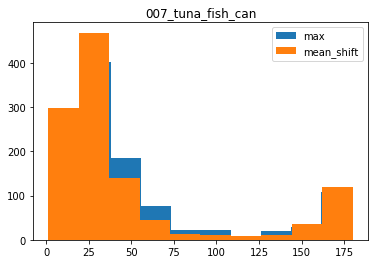

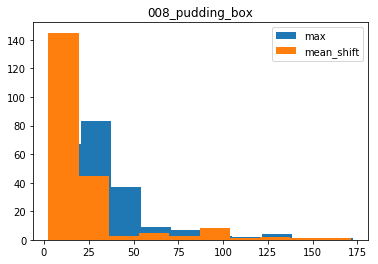

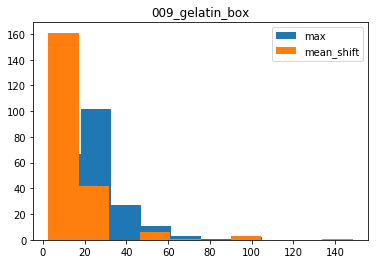

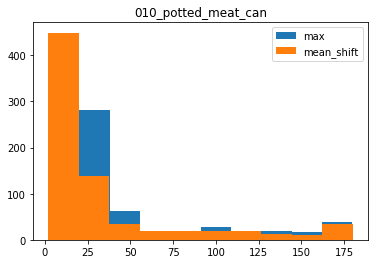

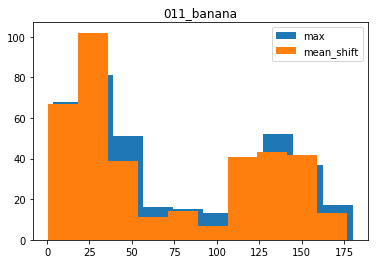

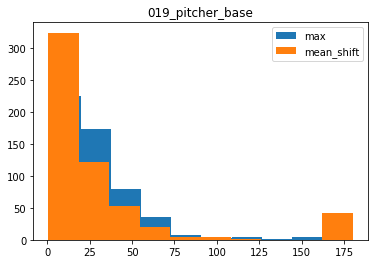

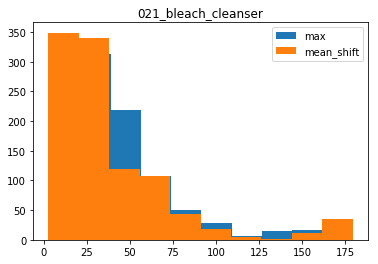

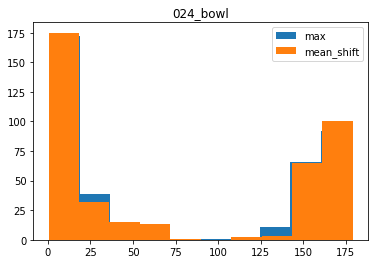

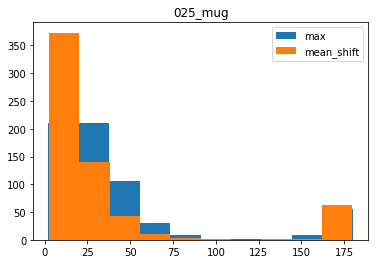

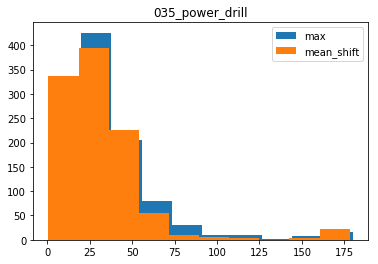

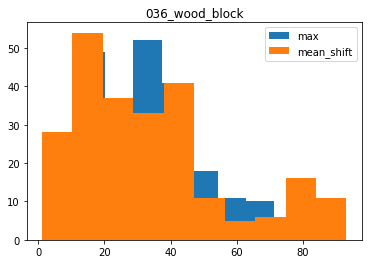

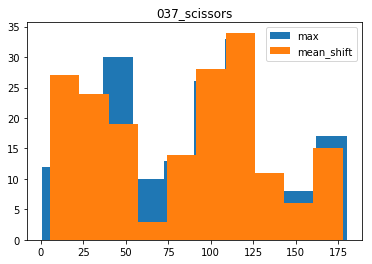

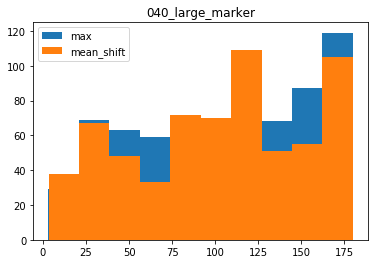

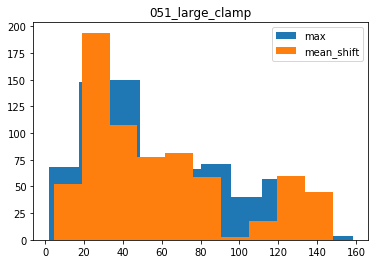

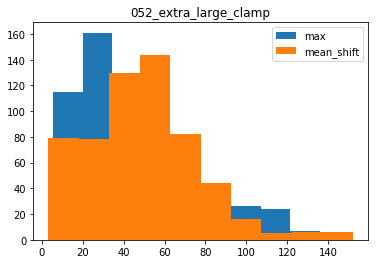

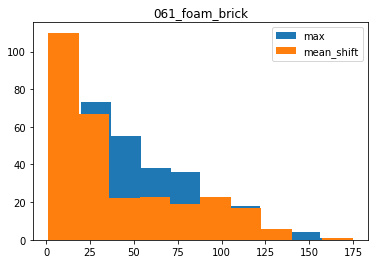

In [196]:
for obj in range(1,22):
    plt.hist(err_compare[obj], label='max')
    plt.hist(err_compare_max_shift[obj], label='mean_shift')
    plt.title(ycb_dataset.classes[obj])
    plt.legend()
    plt.show()

In [3]:
import numpy as np


In [5]:
from mpl_toolkits.mplot3d import Axes3D
cmap = plt.get_cmap('jet')
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
scatterSO3(to_np(grid_vertices), to_np(torch.exp(torch.log(dist_est.flatten())*np.pi/9/sigmas[object_id])),
           [to_np(quat)], alpha_max = .5)
tetra_interp.setValues(to_np(torch.exp(torch.log(dist_est.flatten())*np.pi/9/sigmas[object_id])))
print(tetra_interp.smooth(to_np(quat)))
tetra_interp.setValues(to_np(dist_est.flatten()))
print(tetra_interp.smooth(to_np(quat)))
#pt_gt = quats2Point([pcnn_quat])
#ax.scatter(pt_gt[:,0], pt_gt[:,1], pt_gt[:,2], c='K', marker='x')

NameError: name 'plt' is not defined

array([0.10484988, 0.00935838, 0.16386687, 0.06837537, 0.22288387,
       0.12739236, 0.03190086, 0.18640936, 0.09091786, 0.24542635,
       0.14993485, 0.05444335, 0.20895184, 0.11346034, 0.01796884,
       0.17247734, 0.07698583, 0.23149433, 0.13600283, 0.04051133,
       0.19501982, 0.09952832, 0.00403682, 0.15854531, 0.06305381,
       0.21756231, 0.12207081, 0.0265793 , 0.1810878 , 0.0855963 ,
       0.24010479, 0.14461329, 0.04912179, 0.20363029, 0.10813878,
       0.01264728, 0.16715578, 0.07166427, 0.22617277, 0.13068127,
       0.03518977, 0.18969826, 0.09420676, 0.24871526, 0.15322375,
       0.05773225, 0.21224075, 0.11674925, 0.02125774, 0.17576624,
       0.08027474, 0.23478324, 0.13929173, 0.04380023, 0.19830873,
       0.10281722, 0.00732572, 0.16183422, 0.06634272, 0.22085121,
       0.12535971, 0.02986821, 0.1843767 , 0.0888852 , 0.2433937 ,
       0.1479022 , 0.05241069, 0.20691919, 0.11142769, 0.01593618,
       0.17044468, 0.07495318, 0.22946168, 0.13397017, 0.03847